In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)


In [4]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [11]:
%%R
ps.FQS = subset_samples(physeq, (sample_data(physeq)$Trtmt=="Ferrihydrite"|sample_data(physeq)$Trtmt=="Quartz"|sample_data(physeq)$Trtmt=="Soil"))

In [12]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>1000)

In [13]:
%%R
ps <- physeq.noSmall

In [14]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [15]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", k=3, trymax=40)
ord.full.plot = plot_ordination(ps_snorm, ord.full, axes = c(1,2), justDF = TRUE)
ord.full.plot$Samples = rownames(ord.full.plot)

Run 0 stress 0.1280525 
Run 1 stress 0.1255295 
... New best solution
... procrustes: rmse 0.07004478  max resid 0.1785136 
Run 2 stress 0.1325734 
Run 3 stress 0.1299121 
Run 4 stress 0.1296615 
Run 5 stress 0.1255767 
... procrustes: rmse 0.01165254  max resid 0.06107948 
Run 6 stress 0.1255071 
... New best solution
... procrustes: rmse 0.00511122  max resid 0.02652194 
Run 7 stress 0.1278091 
Run 8 stress 0.1275991 
Run 9 stress 0.1255456 
... procrustes: rmse 0.006369035  max resid 0.03573198 
Run 10 stress 0.1268743 
Run 11 stress 0.1288788 
Run 12 stress 0.1277407 
Run 13 stress 0.128949 
Run 14 stress 0.13211 
Run 15 stress 0.128008 
Run 16 stress 0.129877 
Run 17 stress 0.1284271 
Run 18 stress 0.1300404 
Run 19 stress 0.1303113 
Run 20 stress 0.1279535 
Run 21 stress 0.1273617 
Run 22 stress 0.1261527 
Run 23 stress 0.1292448 
Run 24 stress 0.1284846 
Run 25 stress 0.1283126 
Run 26 stress 0.1269037 
Run 27 stress 0.1254991 
... New best solution
... procrustes: rmse 0.001992

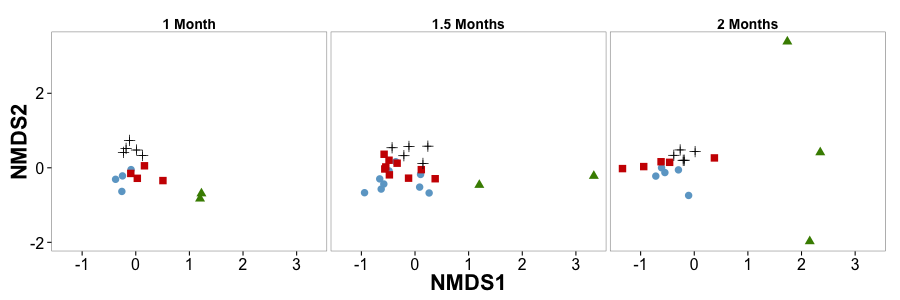

In [30]:
%%R -h 300 -w 900

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"1.5 Months","2 Months"))

p = plot_ordination(ps_snorm, ord.full, color = "Trtmt", shape = "Trtmt")

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend("Mineral"), shape = guide_legend("Mineral"))
# Determines the color theme of the plot overall

p = p + scale_x_continuous(breaks=c(-1,0,1,2,3))
p = p + scale_y_continuous(breaks=c(-2,0,2))

p = p + theme_bw() +
    theme(
    legend.position = "none"
    ,plot.background = element_blank()
    ,panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold")
    ,axis.title = element_text(size=22, face='bold')
    ,axis.text = element_text(size=16)
    ,legend.text = element_text(size=16)
    ,legend.title = element_text(size = 22)
    ,strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [31]:
%%R
ggsave(filename="NMDS-ITS-3month.jpg", plot=p ,width=8.5, height=3.5)

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.